
<a id='dyn-stack'></a>

# L8. DP Squared: Dynamic Duopoly Problems

This lecture is based on the [Quantitative Economics with Julia course](https://julia.quantecon.org/).

## 1. Dynamic Duopoly Setting 
Consider the following setting:
- Time is discrete and is indexed by $ t = 0, 1, \ldots $
- Two firms produce a single good whose demand is governed by the linear inverse demand curve
$$
p_t = a_0 - a_1 (q_{1t}+ q_{2t} )
$$
    where $ q_{it} $ is output of firm $ i $ at time $ t $ and $ a_0 $ and $ a_1 $ are both positive. $q_{10}, q_{20} $ are given numbers that serve as initial conditions at time $ 0 $.

- The per-unit production cost is 0, but there are adjustment costs. By incurring a cost of change
$$
\gamma v_{it}^2
$$
    where $ \gamma > 0 $, firm $ i $ can change its output according to 
$$
q_{it+1} = q_{it} + v_{it}
$$

- Firm $ i $’s profits at time $ t $ equal
$$
\pi_{it}(q_{it}, q_{-it}, v_{it}) = p_t q_{it} - \gamma v_{it}^2 = [a_0 - a_1 (q_{it} + q_{-it} )]q_{it} - \gamma v_{it}^2 
$$

- Firm $ i $ wants to maximize the present value of its profits
$$
\sum_{t=0}^\infty \beta^t \pi_{it}
$$
    where $ \beta \in (0,1) $ is a time discount factor.
    
- Each firm $ i=1,2 $ chooses a sequence $ \vec q_i \equiv \{q_{it+1}\}_{t=0}^\infty $ once and for all at time $ 0 $.

## 2. Markov-Perfect Equilibrium

Markov perfect equilibrium is a refinement of the concept of Nash equilibrium. It is used to study settings where multiple decision makers interact non-cooperatively over time, each seeking to pursue its own objective.

The agents in the model face a **common state vector**. In our case, the common state variables will be $q_{1t}$ and $q_{2t}$. The firms' policy functions are allowed to be a function of that state vector only. At the same time, the law of motion of the state vector is affected by the decision rules of other agents. Individual payoff maximization requires that each agent solve a dynamic programming problem that includes this transition law.

Markov perfect equilibrium prevails when no agent wishes to revise its policy, taking as given the policies of all other agents. In other words, the policy function for each firm is a **best response** to the policy function for the other firm.

### 2.1. LQ programming
It will be very convenient to represent our equations in matrix form. Let $y_t = (1, q_{1t}, q_{2t})^\top$ denote the vector of state variables (and a constant). 

This state vector evolves according to the following law of motion:
$$y_{t+1} = A y_t + B_1 v_{1t} + B_2 v_{2t},$$
where:
$$A = \begin{bmatrix} 1 & 0 & 0 \\
                      0 & 1 & 0 \\
                      0 & 0 & 1 \end{bmatrix}, \quad
B_1 = \begin{bmatrix} 0 \\
                      1 \\
                      0 \end{bmatrix}, \quad
B_2 = \begin{bmatrix} 0 \\
                      0 \\
                      1 \end{bmatrix}$$

The Bellman equation for Firm $i$ is as follows:
\begin{align*}
V_i(y_t) = \max_{v_{it}, y_{t+1}} \quad & \{y_t^\top R_i y_t - \gamma v_{it}^2 + \beta V_i(y_{t+1})\} \\ \text{subj. to} \quad & y_{t+1} = A y_t + B_1 v_{1t} + B_2 v_{2t}
\end{align*}
where:
$$R_1 = \begin{bmatrix} 0 & \frac{a_0}{2} & 0 \\
                      \frac{a_0}{2} & -a_1 & -\frac{a_1}{2}\\
                      0 & -\frac{a_1}{2} & 0 \end{bmatrix} \quad \text{and} \quad
  R_2 = \begin{bmatrix} 0 & 0 & \frac{a_0}{2} \\
                      0 & 0 & -\frac{a_1}{2} \\
                      \frac{a_0}{2} & -\frac{a_1}{2} & -a_1 \end{bmatrix}$$

Why is this beautiful? This is a quadratic dynamic programming problem with a linear constraint. Many results exist that characterize the form of the solution!

In particular, we know the following:
1. The value function will be quadratic in $y_t$, i.e. $V_i(y_t) = y_t^\top P_i y_t$ for some matrix $P_i$. The policy function, on the other hand, will be linear in $y_t$, i.e. the Bellman equation is maximized at $v_{it} = F_i y_{t}$ for some $F_{i}$.

2. $P_i$ solves the [Algebraic Riccati Equation](https://en.wikipedia.org/wiki/Algebraic_Riccati_equation):

    $$P_i = R_i + \beta \Lambda_i^\top P_i \Lambda_i + \beta^2 \Lambda_i^\top P_i B_i [\gamma - \beta B_i^\top P_i B_i]^{-1} B_i^\top P_i \Lambda_i$$

    where $\Lambda_i = A + B_{-i} F_{-i}$, i.e. it is the part of the law of motion that depends on the other firm's policy, which $i$ takes as given.

    In general, the Algebraic Riccati Equation will have multiple solutions, but only one of them will yield non-exploding paths for $y_t$ (i.e. the stable solution), which is required to satisfy the transversality condition. This is challenging to show, but you can look at the reference linked.

3. $F_i, F_{-i}$ are given as the solution to:

    $$F_i = [\gamma - \beta B_i^\top P_i B_i]^{-1} \beta B_i^\top P_i \Lambda_i$$ 

    (notice that $\Lambda_i$ depends on $F_{-i}$, so this is a system of two equations in two unknowns).

*Exercise:* Use a "guess-and-verify" approach (i.e. guess that the value function is $V_i(y_t) = y_t^\top P_i y_t$) to show that the Bellman equation holds with the $P_i$ and $F_i$ above).

### 2.2. Implementation
The package ```QuantEcon.jl``` implements the computation of Markov-perfect equilibria in the LQ framework above (see the [documentation](https://quantecon.org/quantecon-jl/)).

Let us try and implement it manually, just to practice the skills we've learnt in this course!

We will be working with **value function iteration** (L3), which will allow us to solve for $P_i$ without actually solving the Algebraic Riccati Equation algebraically.

Here's an outline of the algorithm:

**Initialize:** Start with a guess for $P_1^{(0)}$, $P_2^{(0)}$, $F_1^{(0)}$ and $F_2^{(0)}$.

For each iteration $k \geq 0$:

1. **Update policy functions:** We know that the RHS of the Bellman equations for Firms 1 and 2 are maximized at $v_{it} = F_i^{(k)} y_t$, where:
    $$\begin{cases}
    F_1^{(k)} = [\gamma - \beta B_1^\top P_1^{(k)} B_1]^{-1} \beta B_1^\top P_1^{(k)} (A + B_{2} F_{2}^{(k)}) \\
    F_2^{(k)} = [\gamma - \beta B_2^\top P_2^{(k)} B_2]^{-1} \beta B_2^\top P_2^{(k)} (A + B_{1} F_{1}^{(k)})
    \end{cases}$$
    You can think of this as a system of two equations in two unknowns $F_1^{(k)}, F_2^{(k)}$. These two equations need to be satisfied simultaneously, which captures the fact that each firm's policy is a best response to the other's policy. Here there are three avenues you can take:
    
    1. Solve the simultaneous equations exactly. These equations are linear, so in fact it is easy here to solve them analytically. In more complicated settings, you can use a non-linear equation solver such as ```NLsolve.jl```. 
    
    2. Perform one *Gauss-Jacobi* iteration (L7), i.e. update policy functions according to:
    $$\begin{cases}
    F_1^{(k)} = [\gamma - \beta B_1^\top P_1^{(k)} B_1]^{-1} \beta B_1^\top P_1^{(k)} (A + B_{2} F_{2}^{(k-1)}) \\
    F_2^{(k)} = [\gamma - \beta B_2^\top P_2^{(k)} B_2]^{-1} \beta B_2^\top P_2^{(k)} (A + B_{1} F_{1}^{(k-1)})
    \end{cases}$$
    
    3. Perform one *Gauss-Seidel* iteration (L7), i.e. update policy functions according to:
    $$\begin{cases}
    F_1^{(k)} = [\gamma - \beta B_1^\top P_1^{(k)} B_1]^{-1} \beta B_1^\top P_1^{(k)} (A + B_{2} F_{2}^{(k-1)}) \\
    F_2^{(k)} = [\gamma - \beta B_2^\top P_2^{(k)} B_2]^{-1} \beta B_2^\top P_2^{(k)} (A + B_{1} F_{1}^{(k)})
    \end{cases}$$
        Notice that, in the second line, we're using the current best guess $F_{1}^{(k)}$. 
   
    Below we show that all three methods converge to the same solution, in the same number of iterations, and all are quite fast.   
   $~$
    
2. **Update value functions:** The Bellman equation is, after replacing the optimal policy functions: 
$$y_t^{\top} P_i y_t = y_t^{\top} R_i y_t - \gamma y_t^{\top} (F_i^{(k)})^{\top} F_i^{(k)} y_t + \beta [(A + B_i F_i^{(k)} + B_{-i}F_{-1}^{(k)}) y_t]^\top P_i [(A + B_i F_i^{(k)} + B_{-i}F_{-1}^{(k)}) y_t],$$
so we can update $P_i$ by matching coefficients as:
$$P_i^{(k+1)} = R_i - \gamma (F_i^{(k)})^{\top} F_i^{(k)} + \beta [(A + B_i F_i^{(k)} + B_{-i}F_{-1}^{(k)})]^\top P_i^{(k)} [(A + B_i F_i^{(k)} + B_{-i}F_{-1}^{(k)})]$$

**Stop criterion:** You can look at the convergence of $P_i$, $F_i$ or both. Stop when the difference between the $k$-th and the $(k+1)$-th iteration is less than some tolerance.

In [1]:
const a0 = 10.0
const a1 = 2.0
const β = 0.96
const γ = 120.0
const T = 100;

In [2]:
using LinearAlgebra, Plots

In [3]:
A_mark = I + zeros(3, 3);
B1_mark = [0, 1, 0]
B2_mark = [0, 0, 1]
R1_mark = [0 a0/2 0; a0/2 -a1 -a1/2; 0 -a1/2 0]
R2_mark = [0 0 a0/2; 0 0 -a1/2; a0/2 -a1/2 -a1]

sup_norm(x) = maximum(abs.(x))

function markov_NE(A = A_mark, B1 = B1_mark, B2 = B2_mark, R1 = R1_mark, R2 = R2_mark;
                   tol = 1e-10, maxiter = 10000, method = "gauss-jacobi")
    
    # Initialize Value Functions
    P1 = zero(A_mark)
    P2 = zero(A_mark)
    
    n = size(A_mark)[2]
    
    # Initialize Policy Functions
    F1 = ones(1, n)
    F2 = ones(1, n)
    
    err = 1.0
    iter = 1

    while err > tol
        
        # Solve Equations for F1 and F2 simultaneously
        H1 = inv(γ .- β * B1' * P1 * B1) * β * B1' * P1
        H2 = inv(γ .- β * B2' * P2 * B2) * β * B2' * P2
        
        if method == "gauss-jacobi"
            F1_next = H1 * (A .+ B2 * F2)
            F2_next = H2 * (A .+ B1 * F1)
        
        elseif method == "gauss-seidel"
            F1_next = H1 * (A .+ B2 * F2)
            F2_next = H2 * (A .+ B1 * F1_next)
            
        elseif method == "analytic"
            # F1 = H1 * (A + B2 * F2) 
            # F2 = H2 * (A + B1 * F1)
            # =>
            # (1 - H1 * B2 * H2 * B1) * F1 = H1 * (A + B2 * H2 * A)
        
            F1_rhs = H1 * (A .+ B2 * H2 * A)
            F1_lhs = 1.0 .- H1 * B2 * H2 * B1
        
            F1_next = F1_lhs \ F1_rhs
            F2_next = H2 * (A .+ B1 * F1_next)
        
        else
            error("Method $method not implemented")
        end
        
        Λ = A .+ B1 * F1_next .+ B2 * F2_next 
        
        # Bellman Iteration
        P1_next = R1 .- γ * F1_next' * F1_next .+ β * Λ' * P1 * Λ
        P2_next = R2 .- γ * F2_next' * F2_next .+ β * Λ' * P2 * Λ
        
        err = sup_norm(F1_next .- F1) + sup_norm(F2_next .- F2) + sup_norm(P1_next .- P1) + sup_norm(P2_next .- P2)
        iter = iter + 1
        
        if iter > maxiter
            error("Reached max iterations, no convergence")
        end
        
        P1 = P1_next
        F1 = F1_next
        P2 = P2_next
        F2 = F2_next
    end
    
    return P1, P2, F1, F2, iter
    
end

res_GJ = markov_NE(method = "gauss-jacobi");
@time markov_NE(method = "gauss-jacobi");
@show iter = res_GJ[end];

res_GS = markov_NE(method = "gauss-seidel");
@time markov_NE(method = "gauss-seidel");
@show iter = res_GS[end];

res_A = markov_NE(method = "analytic");
@time markov_NE(method = "analytic");
@show iter = res_A[end];

@show sup_norm(res_GJ[1] .- res_GS[1]);
@show sup_norm(res_GJ[1] .- res_A[1]);
@show sup_norm(res_A[1] .- res_GS[1]);

P1_mark, P2_mark, F1_mark, F2_mark, _ = res_GS;

  0.001242 seconds (41.63 k allocations: 2.523 MiB)
iter = res_GJ[end] = 622
  0.001285 seconds (41.62 k allocations: 2.503 MiB)
iter = res_GS[end] = 622
  0.001343 seconds (45.96 k allocations: 2.673 MiB)
iter = res_A[end] = 622
sup_norm(res_GJ[1] .- res_GS[1]) = 1.1510792319313623e-12
sup_norm(res_GJ[1] .- res_A[1]) = 1.1084466677857563e-12
sup_norm(res_A[1] .- res_GS[1]) = 2.2595258997171186e-12


Let's plot the evolution of total output and total price starting from $q_{10} = q_{20} = 1$! We can find these by replacing the policy functions into the law of motion.

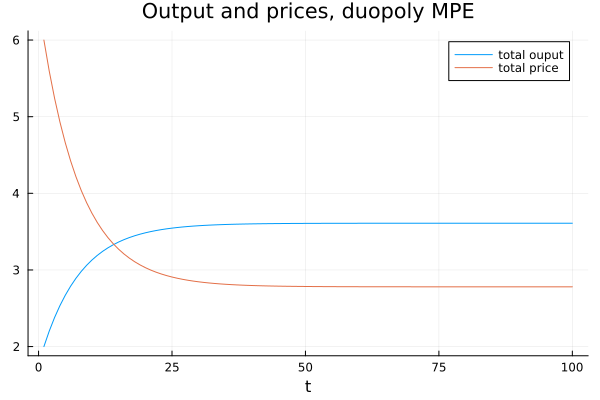

In [4]:
y0 = [1., 1., 1.]

function ForwardIter(y0::Vector{Float64}, M::Matrix{Float64})
    yt = zeros(Float64, length(y0), T)
    yt[:,1] = y0
    for t = 1:T-1
        yt[:,t+1] = M * yt[:,t]
    end
    return yt
end

yt_mark = ForwardIter(y0, A_mark .+ B1_mark * F1_mark .+ B2_mark * F2_mark);

q1 = yt_mark[2, :];
q2 = yt_mark[3, :];

q = q1 + q2; # total output, MPE
p = a0 .- a1 * q; # total price, MPE

plot([q, p], labels = ["total ouput" "total price"], title = "Output and prices, duopoly MPE", xlabel = "t")

## 3. Stackelberg Equilibrium
Now we consider a slightly different game:

- We let firm 2 be a **Stackelberg leader** and firm 1 be a **Stackelberg follower**. The leader firm 2 goes first and chooses $ \{q_{2t+1}\}_{t=0}^\infty $ once and for all at time $ 0 $. Knowing that firm 2 has chosen $ \{q_{2t+1}\}_{t=0}^\infty $, the follower firm 1 goes second and chooses $ \{q_{1t+1}\}_{t=0}^\infty $ once and for all at time $ 0 $. In choosing $ \vec q_2 $, firm 2 takes into account that firm 1 will base its choice of $ \vec q_1 $ on firm 2’s choice of
$ \vec q_2 $.

Our equilibrium concept now will be a **Stackelberg** equilibrium:

We can express firm 1’s (the follower's) problem as

$$
\max_{\vec q_1} \Pi_1(\vec q_1; \vec q_2)
$$

where the appearance behind the semi-colon indicates that
$ \vec q_2 $ is given.

Firm 1’s problem induces a best response mapping

$$
\vec q_1 = B(\vec q_2)
$$

(Here $ B $ maps a sequence into a sequence)

Firm 2's (the leader’s) problem is

$$
\max_{\vec q_2} \Pi_2 (B(\vec q_2), \vec q_2)
$$

whose maximizer is a sequence $ \vec q_2 $ that depends on the
initial conditions $ q_{10}, q_{20} $ and the parameters of the
model $ a_0, a_1, \gamma $.

This formulation captures key features of the model

- Both firms make once-and-for-all choices at time $ 0 $.  
- This is true even though both firms are choosing sequences of
  quantities that are indexed by **time**.  
- The Stackelberg leader chooses first **within time** $ 0 $,
  knowing that the Stackelberg follower will choose second **within
  time** $ 0 $.  

### 3.1. Preliminary Calculations: Follower's Problem
In the spirit of **backward induction**, let's analyze Firm 1's problem first.

The Bellman equation for the follower is:
$$V_1(q_{1t}) = \max_{v_{1t}, q_{1t+1}} \{[a_0 - a_1 (q_{1t}+ q_{2t})]q_{1t} - \gamma v_{1t}^2 + \beta V_1(q_{1t+1})\} \quad \text{subj. to} \quad q_{1t+1} = q_{1t} + v_{1t}.$$
The value function also depends on $q_{2t}$, but we suppress the notation since Firm 1 takes $q_{2t}$ as given.

The FOC are:
\begin{align*}
\beta V'_1(q_{1t+1}) & = \lambda_t \\
2\gamma v_{1t} & = \lambda_t,
\end{align*} where $\lambda_t$ is the Lagrange multiplier on $q_{1t} + v_{1t} - q_{1t+1} = 0$.

By the Envelope Theorem:
$$V'_1(q_{1t}) = a_0 - 2a_1 q_{1t} - a_1 q_{2t} + \lambda_t$$

Shifting one period forward and replacing $V'_1(q_{1t+1})$, we have: $$\lambda_t = \beta (a_0 - 2a_1 q_{1t+1} - a_1 q_{2t+1} + \lambda_{t+1}).$$

Finally, using the 2nd FOC, we get the following **Euler equation**:
$$v_{1t} = \frac{\beta a_0}{2\gamma} - \frac{\beta a_1}{\gamma} q_{1t+1} - \frac{\beta a_1}{2 \gamma} q_{2t+1} + \beta v_{1t+1}.$$

Let's stop here for now and continue.

### 3.2. Leader's Problem
What are the state variables for Firm 2? There are two types:
1. _Natural State Variables_: these are fixed at the beginning of period $t$, something "inherited from the past," including $q_{1t}$ and $q_{2t}$. 
2. _Endogenous State Variables_: these are "free to jump" at period $t$. They are endogenous and forward-looking, a product of a decision made by the follower at time $t$, as a best response to the entire sequence of decisions made by leader. They include $v_{1t}$ (which depends on future values via the Euler equation).

Note that we have an initial condition for $q_{10}$ and $q_{20}$ but not for $v_{10}$. In fact, $v_{10}$ is among the variables to be chosen at time $0$ by the Stackelberg leader (who anticipates how the follower will best-respond). Therefore, we can consider two sub-problems:
1. Given $v_{10}$, find the optimal path $\{v_{2t}, q_{1t+1}, q_{2t+1}, v_{1t+1}\}_{t=0}^\infty$, and the associated value function.
2. Find $v_{10}$ by maximizing the value function above.

#### 3.2.1. Subproblem 1
The Bellman equation for Firm 2 needs to take into account the law of motion for all these variables:
\begin{align*}
V_2(q_{1t}, q_{2t}, v_{1t}) = \max_{v_{2t}, q_{1t+1}, q_{2t+1}, v_{1t+1}} \quad & \{[a_0 - a_1 (q_{1t}+ q_{2t})]q_{2t} - \gamma v_{2t}^2 + \beta V_2(q_{1t+1}, q_{2t+1}, v_{1t+1})\} \\ \text{subj. to} \quad & q_{1t+1} = q_{1t} + v_{1t} \\ & q_{2t+1} = q_{2t} + v_{2t} \\ & v_{1t} = \frac{\beta a_0}{2\gamma} - \frac{\beta a_1}{\gamma} q_{1t+1} - \frac{\beta a_1}{2 \gamma} q_{2t+1} + \beta v_{1t+1}.
\end{align*}


**LQ Programming:** This problem admits a LQ programing representation, as above. Let $y_t = (1, q_{1t}, q_{2t}, v_{1t})$ denote the vector of state variables (and a constant). Note that now we're also keeping track of the endogenous state variable $v_{1t}$, which is the result of Firm 1's choice according to its best response. The law of motion for the state variables is:

$$\begin{bmatrix} 1 & 0 & 0 & 0 \\
                      0 & 1 & 0 & 0 \\
                      0 & 0 & 1 & 0 \\
                      \frac{\beta a_0}{2\gamma} & - \frac{\beta a_1}{\gamma} & -\frac{\beta a_1}{2 \gamma} & \beta \end{bmatrix} \begin{bmatrix} 1 \\
                      q_{1t+1} \\
                      q_{2t+1} \\
                      v_{1t+1} \end{bmatrix} = \begin{bmatrix} 1 & 0 & 0 & 0 \\
                      0 & 1 & 0 & 1 \\
                      0 & 0 & 1 & 0 \\
                      0 & 0 & 0 &1 \end{bmatrix} \begin{bmatrix} 1 \\
                      q_{1t} \\
                      q_{2t} \\
                      v_{1t} \end{bmatrix} + \begin{bmatrix} 0 \\
                      0 \\
                      1 \\
                      0 \end{bmatrix} v_{2t},$$

or, solving:

$$y_{t+1} = A y_t + B v_{2t},$$

where:
$$A = \begin{bmatrix} 1 & 0 & 0 & 0 \\
                      0 & 1 & 0 & 0 \\
                      0 & 0 & 1 & 0 \\
                      \frac{\beta a_0}{2\gamma} & - \frac{\beta a_1}{\gamma} & -\frac{\beta a_1}{2 \gamma} & \beta \end{bmatrix}^{-1}
                      \begin{bmatrix} 1 & 0 & 0 & 0 \\
                      0 & 1 & 0 & 1 \\
                      0 & 0 & 1 & 0 \\
                      0 & 0 & 0 &1 \end{bmatrix}, \quad 
  B = \begin{bmatrix} 1 & 0 & 0 & 0 \\
                      0 & 1 & 0 & 0 \\
                      0 & 0 & 1 & 0 \\
                      \frac{\beta a_0}{2\gamma} & - \frac{\beta a_1}{\gamma} & -\frac{\beta a_1}{2 \gamma} & \beta \end{bmatrix}^{-1} \begin{bmatrix} 0 \\
                      0 \\
                      1 \\
                      0 \end{bmatrix},$$

The Bellman equation is:
\begin{align*}
V_2(y_t) = \max_{v_{2t}, y_{t+1}} \quad & \{y_t^\top R y_t - \gamma v_{2t}^2 + \beta V_2(y_{t+1})\} \\ \text{subj. to} \quad & y_{t+1} = A y_t + B v_{2t}.
\end{align*}

where now:
$$R = \begin{bmatrix} 0 & 0 & \frac{a_0}{2} & 0 \\
                      0 & 0 & -\frac{a_1}{2} & 0 \\
                      \frac{a_0}{2} & -\frac{a_1}{2} & -a_1 & 0 \\
                      0 & 0 & 0 &0 \end{bmatrix}$$

By the same reasoning as above, the solution to the Bellman equation will be quadratic, $V_2(y_t) = y_t^\top P y_t$ for a $P$ satisfying the Algebraic Riccati Equation with the new $A, B, R$. The associated policy function will be linear, $v_{2t} = F y_t$. We implement these numerically below:

**Approach 1: Value Function Iteration.** This is just what we did above to find the Markov-perfect equilibrium. 

In [5]:
R = [0 0 a0/2 0; 0 0 -a1/2 0; a0/2 -a1/2 -a1 0; 0 0 0 0]
L = [1 0 0 0; 0 1 0 0; 0 0 1 0; β*a0/(2.0*γ) -β*a1/γ -β*a1/(2*γ) β]
A = inv(L) * [1 0 0 0; 0 1 0 1; 0 0 1 0; 0 0 0 1]
B = inv(L) * [0, 0, 1, 0];

In [6]:
function VF_iter(A = A, B = B, R = R; tol = 1e-10, maxiter = 10000)
    
    P = zero(A)
    F = inv(γ - β * B' * P * B) * β * B' * P * A
    
    err = 1.0
    iter = 1
    
    while err > tol
        P_next = R - γ * F' * F + β * (A + B * F)' * P * (A + B * F)
        F_next = inv(γ - β * B' * P * B) * β * B' * P * A
        
        err = sup_norm(P .- P_next) + sup_norm(F .- F_next)
        iter = iter + 1
        
        P = copy(P_next)
        F = copy(F_next)
        
        if iter > maxiter
            error("Reached max iterations, no convergence")
        end
    end
    
    return P, F, iter
end

res_VF = VF_iter();
@time res_VF;
@show iter = res_VF[end];

  0.000001 seconds
iter = res_VF[end] = 641



**Approach 2: Policy Function Iteration.** Another possible approach is policy function iteration (L3). We review it here and show what it would look like for this problem.

We start with a (linear) guess $F^{(0)} y_t$ for the policy function. 

Given that guess, $y_t$ evolves as: $y_{t+1} = H^{(0)}y_t$, where $H^{(0)} = A + BF^{(0)}$. 

We can compute the value function:
$$\sum_{t=0}^\infty \beta^t [y_t^\top R y_t - \gamma y_t^\top  (F^{(0)})^\top F^{(0)} y_t] = y_t \left(\sum_{t=0}^\infty \beta^t (H^{(0)})^t [R - \gamma (F^{(0)})^\top F^{(0)})] (H^{(0)})^t \right) y_t \approx y_t^\top P^{(0)} y_t$$
where $P^{(0)} = \sum_{t=0}^T \beta^t (H^{(0)})^t [R - \gamma (F^{(0)})^\top F^{(0)}] (H^{(0)})^t$ for some large $T$.

With that, we can build the RHS of the Bellman equation, and update our policy function to be its maximizer. As we saw above, that will be:
$$F^{(1)} = [\gamma - \beta B^\top P^{(0)} B]^{-1} \beta B^\top P^{(0)} A$$

We can continue iterating this way until convergence of $P$ and $F$ to the desired tolerance.

In [7]:
function PF_iter(A = A, B = B, R = R; tol = 1e-10, maxiter = 1000)
    
    P = zero(A)
    F = ones(1, size(A)[1])
    
    err = 1.0
    iter = 1
    
    while err > tol
        
        h = A .+ B * F
        P_next = R .- γ * F' * F
        
        for t = 1:(4*T)
            P_next = P_next .+ β^t * (h')^t * (R .- γ * F'F) * h^t
        end
        
        F_next = inv(γ .- β * B' * P_next * B) * β * B' * P_next * A
        
        err = sup_norm(P .- P_next) + sup_norm(F .- F_next)
        iter = iter + 1
        
        P = copy(P_next)
        F = copy(F_next)
        
        if iter > maxiter
            error("Reached max iterations, no convergence")
        end
    end
    
    return P, F, iter
end

res_PF = PF_iter();
@time res_PF;
@show iter = res_PF[end];

@show sup_norm(res_PF[1] .- res_VF[1]);

P, F, _ = res_PF;

  0.000000 seconds
iter = res_PF[end] = 15
sup_norm(res_PF[1] .- res_VF[1]) = 1.2147829352215922e-5


Policy function iteration converges in fewer iterations, but both methods are very fast and give the same results.

#### 3.2.2. Subproblem 2
This is the easy part! We have found the value function: $V_2(y_0) = y_0^\top P y_0$. Now we have to find the $v_{10}$ that maximizes this. Remember that $v_{1t}$ is the last component of $y_t$. To do that, we take the FOC of $V_2(y_0)$ with respect to $v_{10}$.

Let's partition the matrix $W$ into blocks: $$P = \begin{bmatrix} P_{11} & P_{12} \\ P_{12}^\top & P_{22}\end{bmatrix},$$ 

where $P_{11}$ is the top-left $3\times 3$ sub-matrix, $P_{12}$ is the top-right $3 \times 1$ sub-matrix, and $P_{22}$ is the $1\times 1$ is the bottom-right block. Then, the FOC is:
$$2P_{12}^\top z_0 + 2P_{22} v_{10} = 0 \quad \Leftrightarrow \quad v_{10} = - P_{22}^{-1} P_{12}^\top z_0,$$ 

where $z_0 = (1, q_{10}, q_{20})^\top$ are the pre-determined components in $y_{0}$.

In [8]:
z0 = [1., 1., 1.]
v10 = -dot(P[4,1:3], z0) / P[4,4]
y0 = vcat(z0, v10)

yt = ForwardIter(y0, A .+ B * F);

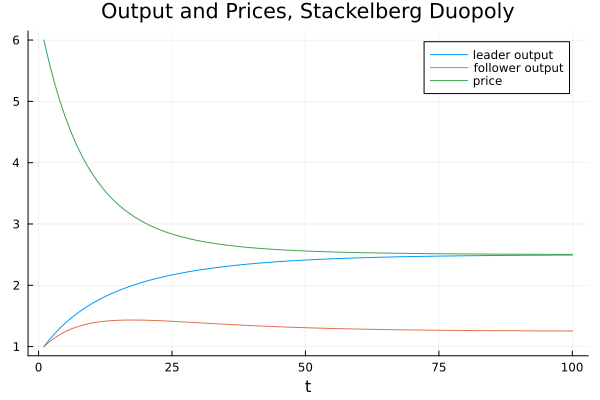

In [9]:
q_follower = yt[2, :]
q_leader = yt[3, :]
q = q_leader + q_follower
p = a0 .- a1*q

plot(1:T, [q_leader, q_follower, p],
    title = "Output and Prices, Stackelberg Duopoly",
    labels = ["leader output" "follower output" "price"],
    xlabel = "t")

### 3.3. Properties of the Stackelberg Solution

#### 3.3.1. Time (In-)Consistency of the Leader's Problem

If the Stackelberg leader was able to re-choose its production plan at some point in the future, would it stick to the plan that is optimal from the perspective of period 0? In other words, is the Stackelberg leader's plan **time consistent**?

Below, we will compare two quantities:
1. The continuation value $V_2(y_t) = y_t^\top P y_t$ earned by a continuation Stackelberg leader who inherits state $y_t$ at $t$.
2. The value of a reborn Stackelberg leader who inherits state $z_t = (1, q_{1t}, q_{2t})^\top$ at $t$ but is able to re-set the jump state variable $v_{1t} = - P_{22}^{-1} P_{12}^\top z_t$ (as if the leader was back in period 0). 

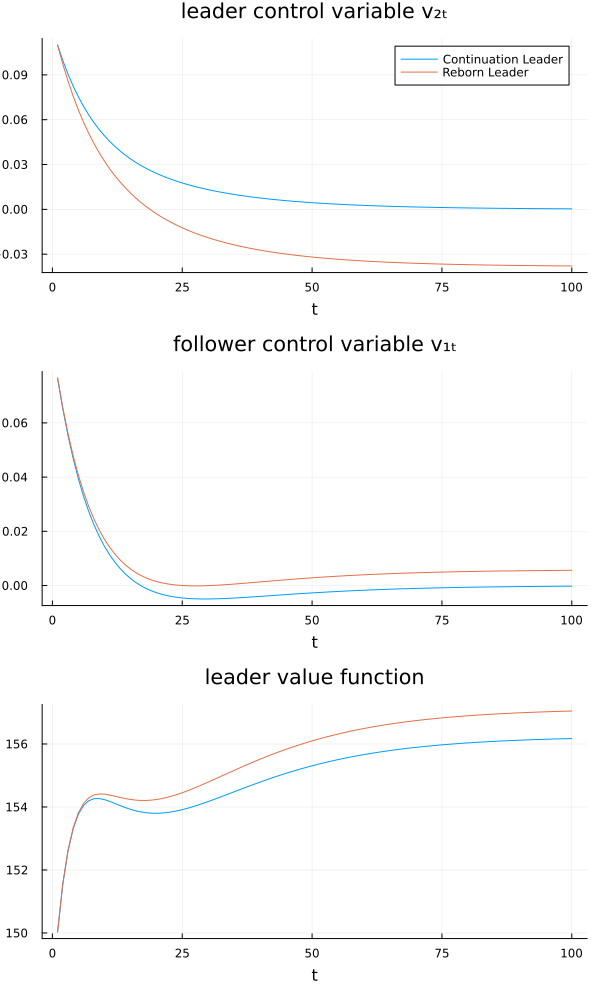

In [10]:
vt_leader = zeros(T)
vt_reset_leader = similar(vt_leader)

yt_reset = copy(yt)
yt_reset[end, :] = -P[4,1:3]' * yt[1:3, :] ./ P[4,4]

for t in 1:T
    vt_leader[t] = yt[:, t]' * P * yt[:, t]
    vt_reset_leader[t] = yt_reset[:, t]' * P * yt_reset[:, t]
end

p1 = plot(1:T, [(F * yt)', (F * yt_reset)'], labels = ["Continuation Leader" "Reborn Leader"],
        title = "leader control variable v₂ₜ", xlabel = "t");
p2 = plot(1:T, [yt[4, :], yt_reset[4, :]], title = "follower control variable v₁ₜ", xlabel = "t", legend = false);
p3 = plot(1:T, [vt_leader, vt_reset_leader], legend = false,
            xlabel = "t", title = "leader value function");
plot(p1, p2, p3, layout = (3, 1), size = (600, 1000))

As you can see, if the Stackelberg leader was re-born in time $t$, they would choose a smaller quantity adjustment $v_{2t}$ for themselves, and as a consequence, a larger quantity adjustment for the follower $v_{1t}$.

To see why the time inconsistency arises, it is useful to represent the leader's choices recursively. Remember the policy function and law of motion for the state variables:
\begin{align*}
v_{10} & = -P_{22}^{-1} P_{12}^\top z_0 \\
v_{2t} & = F y_t \qquad t \geq 0\\
y_{t+1} & = Ay_t + Bv_{2t} = (A + BF) y_t \qquad t \geq 0.
\end{align*}

What is the path for the leader's control variable? 

Denote $H_0^0 \equiv -P_{22}^{-1} P_{12}^\top$, and $\check{A} = A + BF$. Partition matrix $\check{A}$ in blocks as: $$\check{A} = \begin{bmatrix} \check{A}_{11} & \check{A}_{12} \\ \check{A}_{21} & \check{A}_{22}\end{bmatrix},$$ where $\check{A}_{11}$ is the top $3 \times 3$ sub-matrix.

Then, the follower control variable evolves as:
\begin{align}
v_{11} &= (\check{A}_{21} + \check{A}_22 H_0^0) z_0 \\
v_{12} &= \check{A}_{21} (\check{A}_{21} + \check{A}_22 H_0^0) z_0 + \check{A}_{22} \check{A}_{21} z_1\\
& \vdots \\
v_{1t} &= \sum_{j=1}^t H_j^t z_{t-j}
\end{align}

where $H_1^t = \check{A}_{21}$, $H_2^t = \check{A}_{22} \check{A}_{21}$, $\ldots$, $H_{t-1}^t = \check{A}_{22}^{t-2} \check{A}_{21}$, $H_2^t = \check{A}_{22}^{t-1} (\check{A}_{21} + H_0^0)$.

Partitioning matrix $F = [F_1 \quad F_2]$, where $F_1$ are the components corresponding to $z_t$, the leader control variable evolves as:
$$v_{2t} = F_1 z_t + F_2 v_{1t} = F_1 z_t + F_2 \sum_{j=1}^t H_j^t z_{t-j}.$$

Therefore, unless $F_2 = 0$ (which is typically not the case), the leader's plan is **history-dependent**, i.e. it depends on the whole history of states $(z_0, \ldots, z_t)$ and not only on $z_t$.

This explains the discrepancy between the continuation value and the value for the reborn leader at time $t$: the quantity $q_{2t+1}$ that the leader choose at time $0$ for time $t+1$ is optimal only when you take into account the previous levels of $q_{2s}$, $s \leq t$. If the leader was re-born, forgot its history, and could start again from scratch, it would realize that this quantity is too large, and would like to increase by a smaller $v_{2t}$ than planned.

#### 3.3.2. Back to the Follower's Problem: Rational Expectations

Can we express the Follower's Problem in the same LQ programming form? The answer is yes, but with a little trick first. The reason is that $q_{2t}$ is among the state variables for Firm 1, but the law of motion that governs $q_{2t}$ depends on $q_{1t}$ and $v_{1t}$, which are endogenous to Firm 1's choice.

The trick we are going to use is sometimes called "Big $K$, small $k$" in macro (see the [Rational Expectations Equilibrium lecture](https://julia.quantecon.org/multi_agent_models/rational_expectations.html) on Quantitative Economics with Julia). The idea is to introduce two new variables: $\tilde{q}_{1t}, \tilde{v}_{1t}$, which represent the **beliefs** about what Firm 1 will do. The law of motion for $q_{2t}$ will, therefore, depend on $(1, \tilde{q}_{1t}, q_{2t}, \tilde{v}_{1t})$. On the other hand, the payoffs of Firm 1 will depend on the **actual** values $q_{1t}, v_{1t}$, where $v_{1t}$ is the control variable.

This specification assures that from the point of the view of a firm 1, $q_{2t}$ is an exogenous process.

Here
- $\tilde{q}_{1t}, \tilde{v}_{1t}$ play the role of Big $K$.
- $q_{1t}, v_{1t}$ play the role of little $k$.
 
We augment the problem to accomodate the new state variables. Notice that the first four entries in $\tilde{y}_t$ correspond to the old $y_t$, and so, the law of motion for them is $(A + BF)y_t$, where $F y_t$ is Firm 2's policy function: 
\begin{align*}
V_1(\tilde{y}_t) = \max_{v_{1t}, \tilde{y}_{t+1}} \quad & \{\tilde{y}_t^\top \tilde{R} \tilde{y}_t - \gamma v_{2t}^2 + \beta V_1(\tilde{y}_{t+1})\} \\ \text{subj. to} \quad & \tilde{y}_{t+1} = \tilde{A} \tilde{y}_t + \tilde{B} v_{2t}.
\end{align*}

where:
$$\tilde{y}_t = \begin{bmatrix} 1 \\ \tilde{q}_{1t} \\ q_{2t} \\ \tilde{v}_{1t} \\ q_{1t} \end{bmatrix}, \quad
\tilde{R} = \begin{bmatrix} 0 & 0 & 0 & 0 & \frac{a_0}{2} \\
                      0 & 0 & 0 & 0 & 0\\
                      0 & 0 & 0 & 0 & -\frac{a_1}{2}\\
                      0 & 0 & 0 & 0 & 0\\
                      \frac{a_0}{2} & 0 & -\frac{a_1}{2} & 0 & -a_1 \end{bmatrix}, \quad
\tilde{A} = \begin{bmatrix} A + BF & 0 \\
                      0 & 1 \end{bmatrix}, \quad 
\tilde{B} = \begin{bmatrix} 0 \\
                      0 \\
                      0 \\
                      0 \\
                      1 \end{bmatrix}.$$
                      

In [11]:
Ã = I + zeros(5, 5)
Ã[1:4, 1:4] .= A .+ B * F
R̃ = [0 0 0 0 a0/2; 0 0 0 0 0; 0 0 0 0 -a1/2; 0 0 0 0 0; a0/2 0 -a1/2 0 -a1]
B̃ = [0, 0, 0, 0, 1]

P̃, F̃, iter = PF_iter(Ã, B̃, R̃);

In an equilibrium with **rational expectations**, it must be the case that $\vec{q}_{1t} = \vec{\tilde{q}}_{1t}$. This will be true here, since the policy function for Firm 2, $F$, is based on the true policy function for Firm 1

maximum(abs.(ỹt[2, :] .- ỹt[5, :])) = 6.661338147750939e-16


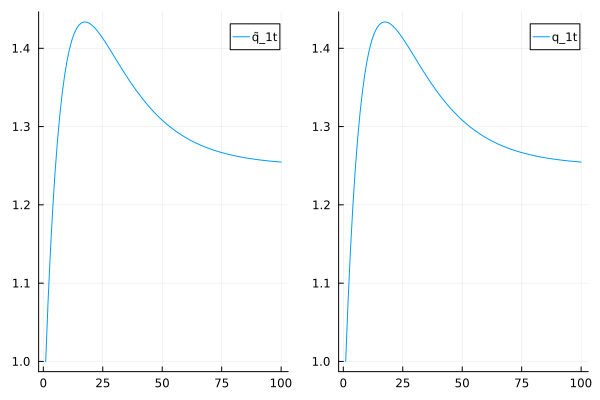

In [12]:
ỹ0 = vcat(y0, y0[2])

ỹt = ForwardIter(ỹ0, Ã .+ B̃ * F̃);

@show maximum(abs.(ỹt[2, :] .- ỹt[5, :]))

plot1 = plot(1:T, ỹt[2, :], label = "q̃_1t");
plot2 = plot(1:T, ỹt[5, :], label = "q_1t");
plot(plot1, plot2, layout = (1, 2))

Moreover, the follower's problem is **time consistent**, since it is recursive in its state variables. In other words,
$$v_{1t} = F \tilde{y}_t,$$ so Firm 1's choice is a function of $\tilde{y}_t = (1, \tilde{q}_{1t}, q_{2t}, \tilde{v}_{1t}, q_{1t})$ only, and not of previous values. If you think about it, none of the state variables is a jump variable from the perspective of Firm 1.

## 4. Comparison of Markov-Perfect and Stackelberg Equilibria

Let's look at how the continuation value evolves in the Markov-perfect vs. the Stackelberg equilibria:

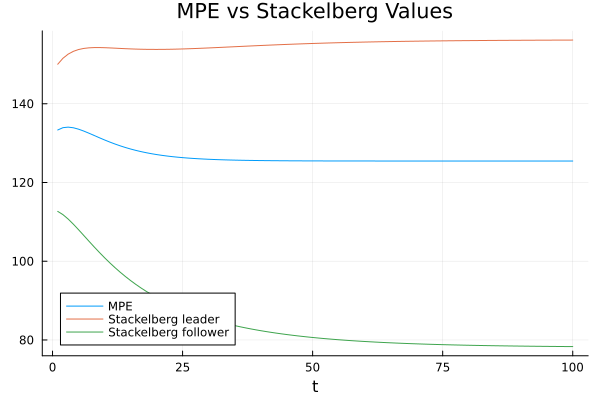

In [13]:
vt_MPE = zeros(T);
vt_follower = zeros(T);

for t in 1:T
    vt_MPE[t] = yt_mark[:, t]' * P1_mark * yt_mark[:, t];
    vt_follower[t] = ỹt[:, t]' * P̃ * ỹt[:, t];
end

plot([vt_MPE, vt_leader, vt_follower], labels = ["MPE" "Stackelberg leader" "Stackelberg follower"], 
        title = "MPE vs Stackelberg Values",
        xlabel = "t")

Compared to the MPE, in which both firms choose their production plan simultaneously, the Stackelberg equilibrium exhibits a **first-mover advantage:** the Stackelberg leader is able to exploit the fact that the follower's decisions depend on their own!

## Additional Resources
- Quantitative Economics with Julia: [Markov Perfect Equilibrium](https://julia.quantecon.org/multi_agent_models/markov_perf.html), [Dynamic Stackelberg Problems](https://julia.quantecon.org/dynamic_programming_squared/dyn_stack.html)

LQ programming:
- Quantitative Economics with Python: [LQ Control: Foundations](https://python.quantecon.org/lqcontrol.html)
- Quantitative Economics with Julia: [Optimal Taxation in an LQ Economy](https://julia.quantecon.org/dynamic_programming_squared/lqramsey.html)
- The package [MatrixEquations.jl](https://docs.juliahub.com/MatrixEquations/1uOBF/1.2.0/) can find both stable and unstable solutions for the Algebraic Riccati Equation in discrete and continuous time (and other types of matrix equations)

Solving Rational Expectations Models:
- Judd (1998) Chapter 17 and references therein.
